# Training Classifiers (Section 4)

## Import directories

In [1]:
# import OpenCV path
arg_user = 'TOM'
import sys
if (arg_user == 'OREN'):
    sys.path.append('D:\Softwares\Anaconda3\envs\opencv-env\Lib')
elif(arg_user == 'TOM'):
    sys.path.append('C:/Users/user/AppData/Local/conda/conda/envs/opencv-env/Lib/site-packages')

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, ShuffleSplit, KFold
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import cv2
%matplotlib inline

## Load database

In [3]:
df_db_xlsx = pd.ExcelFile("files/database_reduced.xlsx")
df_db = pd.read_excel(df_db_xlsx,'database')

In [4]:
levels = 5
features = ['ear','poly']
NUM_FRAMES = 6

In [5]:
# Extract number of blinks
num_blinks = df_db['blink_number'].nunique()

## Add scores from neighboring frames

In [6]:
df_db_offset = df_db.copy()

for offset in range(NUM_FRAMES*(-1), NUM_FRAMES+1):
    # Do something only if the offset isn't zero
    if(offset == 0):
        continue
    
    # Run for each blink
    for blink_number in range(num_blinks):
        
        blink_idx = df_db.loc[df_db['blink_number'] == blink_number].index

        for i in range(len(blink_idx)):
            # Add a column for each selected feature
            for feature in features:
                new_column = feature + '_' + str(offset)
                if (i + offset < 0) or (i + offset > len(blink_idx) - 1):
                    df_db_offset.loc[blink_idx[i], new_column] = 1
                else:
                    df_db_offset.loc[blink_idx[i], new_column]  = df_db_offset.loc[blink_idx[i + offset], feature]

In [7]:
df_db_offset = df_db_offset.reset_index(drop=True)

## Create X and y vectors

In [8]:
# Add the new columns to the feature list
new_features = []

for feature in features:
    add_cols   = [col for col in df_db_offset.columns if col.startswith(feature)]
    new_features = new_features + add_cols
new_features.append('palsy_eye')
print(new_features)

['ear', 'ear_-6', 'ear_-5', 'ear_-4', 'ear_-3', 'ear_-2', 'ear_-1', 'ear_1', 'ear_2', 'ear_3', 'ear_4', 'ear_5', 'ear_6', 'poly', 'poly_-6', 'poly_-5', 'poly_-4', 'poly_-3', 'poly_-2', 'poly_-1', 'poly_1', 'poly_2', 'poly_3', 'poly_4', 'poly_5', 'poly_6', 'palsy_eye']


In [9]:
X = df_db_offset[new_features]
y = np.array([int(l*4) for l in df_db_offset['label']])

## Examine the use of PCA

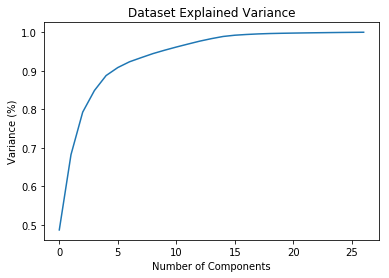

In [10]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(X)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance')
plt.show()

In [11]:
# Pefrorm PCA using a lower number support vectors
model = PCA(n_components=20)            
model.fit(X)                      
X_PCA = model.transform(X)         

## Define function for cross-validation - split using blink number

In [10]:
def cv_blink(df_db_offset, X, y, model, num_cv=5, random_state=0, use_prob=False):
    
    # Define constants
    num_blinks = 436
    num_blinks_normal = 214
    num_blinks_palsy = num_blinks - num_blinks_normal
    
    # Assemble an array saving the blink numbers that are not selected yet
    normal_choice = range(num_blinks_normal)
    palsy_choice  = range(num_blinks_normal, num_blinks)
    
    # Start cross validation
    for i in range(num_cv):
        
        # Randomize blink numbers for the current test set (size around num_blinks / num_cv)
        # Consider the rest as train set
        test_mask = np.zeros(len(X), dtype=bool)
        np.random.seed(random_state); rnd_idx_normal = sorted(np.random.choice(normal_choice, min(len(normal_choice),int(np.round(num_blinks_normal/num_cv))), replace=False))
        np.random.seed(random_state); rnd_idx_palsy = sorted(np.random.choice(palsy_choice, min(len(palsy_choice),int(np.round(num_blinks_palsy/num_cv))), replace=False))
        test_mask = np.zeros(len(X), dtype=bool)
        test_mask[df_db_offset.loc[df_db_offset['blink_number'].isin(rnd_idx_normal)].index] = True
        test_mask[df_db_offset.loc[df_db_offset['blink_number'].isin(rnd_idx_palsy)].index] = True
        Xtest, ytest = X[test_mask], y[test_mask]
        Xtrain, ytrain = X[~test_mask], y[~test_mask]

        # Apply the classifier - train on the train set, then evaluate using the test set
        model.fit(Xtrain, ytrain)                  
        y_model = model.predict(Xtest)             
        
        df_db_test_cv = df_db_offset.iloc[Xtest.index,:][['blink_number','video_name','frame_number','eye_location','palsy_eye','label']]
        df_db_test_cv.loc[:,'prediction'] = y_model / (levels - 1)

        # Add probability estimation info
        if use_prob:
            pred_pro = model.predict_proba(Xtest)
            for j in range(levels):
                col_name = 'prob_' + str(j)
                df_db_test_cv.loc[:,col_name] = pred_pro[:,j] 

        # Update test dataframe
        if i==0:
            df_db_test = df_db_test_cv.copy()
        else:
            df_db_test = pd.concat([df_db_test, df_db_test_cv])

        # Remove the selected blink numbers from the normal and palsy arrays
        normal_choice = [num for num in normal_choice if not (num in rnd_idx_normal)]
        palsy_choice = [num for num in palsy_choice if not (num in rnd_idx_palsy)]

    return df_db_test

## Evaluate performance using only the MINIMUM values from each blink

In [11]:
def eval_blinks(df_db_test):
    
    df_db_test = df_db_test.reset_index(drop=True)
    y_blink_test = []
    y_blink_pred = []

    df_db_blink_res = df_db_test.loc[df_db_test['palsy_eye'] == 1, ['blink_number', 'video_name', 'eye_location']].drop_duplicates().reset_index(drop=True)
    
    for blink in df_db_test['blink_number'].unique():
        palsy_eye = min(df_db_test.loc[df_db_test['blink_number'] == blink]['palsy_eye'])
        if palsy_eye == 1:
            min_label = min(df_db_test.loc[df_db_test['blink_number'] == blink].iloc[1:-1,:]['label'])
            df_db_blink_res.loc[df_db_blink_res['blink_number'] == blink, 'min_label'] = min_label
            #y_blink_test.append(int(min_label * (levels - 1)))
            
            min_pred  = min(df_db_test.loc[df_db_test['blink_number'] == blink].iloc[1:-1,:]['prediction'])
            min_pred_idx = df_db_test.loc[(df_db_test['blink_number'] == blink) & (df_db_test['prediction'] == min_pred)].index
            min_pred_mid = min_pred_idx[min(len(min_pred_idx) - 1, round(len(min_pred_idx)/2))]
            min_locs = df_db_test.loc[df_db_test['blink_number'] == blink].loc[min_pred_mid-1:min_pred_mid+1,:]['prediction'].reset_index(drop=True)
            if len(min_locs) > 2:
                if (min_pred == 0.5 and min_locs[0] == 0.75 and min_locs[2] == 0.75):
                    min_pred_final = min_pred
                elif (min_pred == 0 and min_locs[0] == 0.75 and min_locs[2] == 1):
                    min_pred_final = min_pred
                elif (min_pred == 0 and min_locs[0] == 0.25 and min_locs[2] == 0.5):
                    min_pred_final = min_pred
                elif (min_pred == 0.25 and min_locs[0] == 1 and min_locs[2] == 0.75):
                    min_pred_final = min_pred
                else:
                    min_pred_final = np.median(min_locs)
            else:
                min_pred_final = np.median(min_locs)

            df_db_blink_res.loc[df_db_blink_res['blink_number'] == blink, 'min_pred'] = min_pred_final
            #y_blink_pred.append(int(min_pred_final * (levels - 1))

    return df_db_blink_res

## Try Naive Bayes

In [16]:
nb = GaussianNB()                       # 2. instantiate model
df_db_test = cv_blink(df_db_offset, X, y, nb, num_cv=5, random_state=0, use_prob=False)

Accuracy score using Naive Bayes:  0.4985268120212139


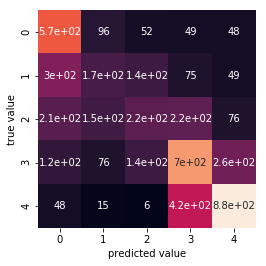

In [17]:
# Evaluate score per frame
y_test = np.array([int(l*(levels-1)) for l in df_db_test['label']])
y_pred = np.array([int(l*(levels-1)) for l in df_db_test['prediction']])

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value')

print('Accuracy score using Naive Bayes: ',accuracy_score(y_test, y_pred))

Accuracy score per blink using Naive Bayes:  0.4090909090909091


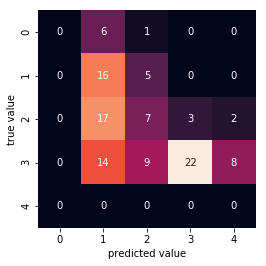

In [18]:
# Evaluate score per blink
df_db_blink_res = eval_blinks(df_db_test)

y_blink_test = np.array([int(l*(levels-1)) for l in df_db_blink_res['min_label']])
y_blink_pred = np.array([int(l*(levels-1)) for l in df_db_blink_res['min_pred']])

mat = confusion_matrix(y_blink_test, y_blink_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value')

print('Accuracy score per blink using Naive Bayes: ',accuracy_score(y_blink_test, y_blink_pred))

## Try Support Vector Machine

### Linear SVM

In [19]:
linsvm = SVC(kernel='linear')
df_db_test = cv_blink(df_db_offset, X, y, linsvm, num_cv=5, random_state=0, use_prob=False)

Accuracy score using Linear SVM:  0.5470438027892359


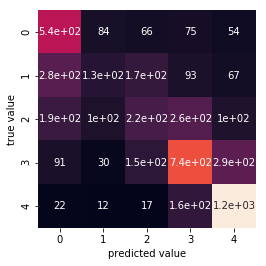

In [20]:
# Evaluate score per frame
y_test = np.array([int(l*(levels-1)) for l in df_db_test['label']])
y_pred = np.array([int(l*(levels-1)) for l in df_db_test['prediction']])

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value')

print('Accuracy score using Linear SVM: ',accuracy_score(y_test, y_pred))

Accuracy score per blink using Linear SVM:  0.45454545454545453


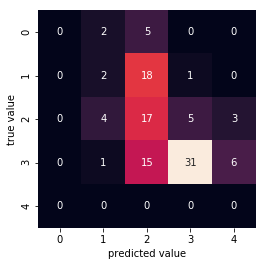

In [21]:
# Evaluate score per blink
df_db_blink_res = eval_blinks(df_db_test)

y_blink_test = np.array([int(l*(levels-1)) for l in df_db_blink_res['min_label']])
y_blink_pred = np.array([int(l*(levels-1)) for l in df_db_blink_res['min_pred']])

mat = confusion_matrix(y_blink_test, y_blink_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value')

print('Accuracy score per blink using Linear SVM: ',accuracy_score(y_blink_test, y_blink_pred))

### RBF SVM

In [12]:
rbfsvm = SVC(kernel='rbf', C=1000, gamma='scale', probability=False, random_state=0)
df_db_test = cv_blink(df_db_offset, X, y, rbfsvm, num_cv=5, random_state=0, use_prob=False)

Accuracy score using RBF SVM:  0.6668630917305048


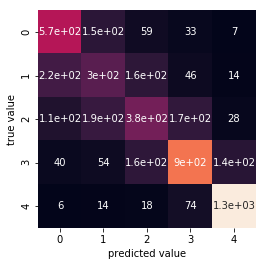

In [13]:
# Evaluate score per frame
y_test = np.array([int(l*(levels-1)) for l in df_db_test['label']])
y_pred = np.array([int(l*(levels-1)) for l in df_db_test['prediction']])

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value')

print('Accuracy score using RBF SVM: ',accuracy_score(y_test, y_pred))

Accuracy score per blink using RBF SVM:  0.7363636363636363


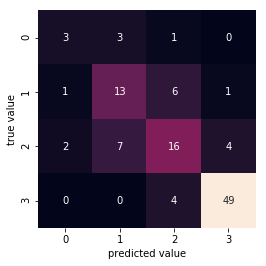

In [14]:
# Evaluate score per blink
df_db_blink_res = eval_blinks(df_db_test)

y_blink_test = np.array([int(l*(levels-1)) for l in df_db_blink_res['min_label']])
y_blink_pred = np.array([int(l*(levels-1)) for l in df_db_blink_res['min_pred']])

mat = confusion_matrix(y_blink_test, y_blink_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value')

print('Accuracy score per blink using RBF SVM: ',accuracy_score(y_blink_test, y_blink_pred))

Accuracy score using RBF SVM for 3-level classification:  0.8190925162050677


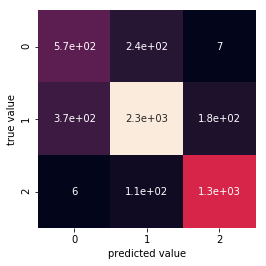

In [24]:
# Evaluate performance using only 3 levels
y_test_3l = y_test
y_pred_3l = y_pred

for i in range(len(y_test)):
    if (y_test[i] == 1) or (y_test[i] == 3):
        y_test_3l[i] = 2
    if (y_pred[i] == 1) or (y_pred[i] == 3):
        y_pred_3l[i] = 2

mat = confusion_matrix(y_test_3l, y_pred_3l)
sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value')

print('Accuracy score using RBF SVM for 3-level classification: ',accuracy_score(y_test_3l, y_pred_3l))

Accuracy score per blink using RBF SVM for 3-level classification:  0.9181818181818182


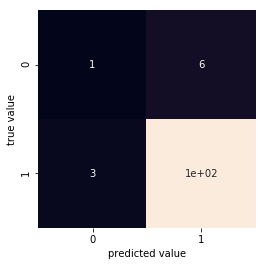

In [26]:
# Evaluate score per blink using only 3 levels
df_db_test_3l = df_db_test.copy()
df_db_test_3l.loc[:,'label'] = y_test_3l / (levels-1)
df_db_test_3l.loc[:,'prediction'] = y_pred_3l / (levels-1)
df_db_blink_res_3l = eval_blinks(df_db_test_3l)

y_blink_test_3l = np.array([int(l*(levels-1)) for l in df_db_blink_res_3l['min_label']])
y_blink_pred_3l = np.array([int(l*(levels-1)) for l in df_db_blink_res_3l['min_pred']])

mat = confusion_matrix(y_blink_test_3l, y_blink_pred_3l)
sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value')

print('Accuracy score per blink using RBF SVM for 3-level classification: ',accuracy_score(y_blink_test_3l, y_blink_pred_3l))

## Save classifier to a variable

In [20]:
from joblib import dump, load

rbfsvm = SVC(kernel='rbf', C=1000, gamma='scale', probability=False, random_state=0)
rbfsvm.fit(X, y)

dump(rbfsvm, 'model.joblib')

['model.joblib']

## Try K-Nearest Neighbors

Max score is:  0.6818181818181818
Using 4 neighbors


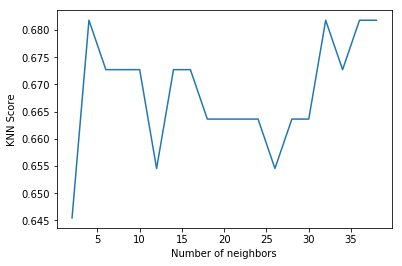

In [254]:
neigh = np.arange(start=2, stop=40, step=2)
scores = []

for n in neigh:
    knn = KNeighborsClassifier(n_neighbors=n, weights='distance')
    df_db_test = cv_blink(df_db_offset, X, y, knn, num_cv=5, random_state=0, use_prob=False)
    df_db_blink_res = eval_blinks(df_db_test)
    y_blink_test = np.array([int(l*(levels-1)) for l in df_db_blink_res['min_label']])
    y_blink_pred = np.array([int(l*(levels-1)) for l in df_db_blink_res['min_pred']])
    scores.append(accuracy_score(y_blink_test, y_blink_pred))

plt.plot(neigh,scores)
plt.xlabel('Number of neighbors')
plt.ylabel('KNN Score')

max_value = max(scores)
max_index = scores.index(max_value)
print('Max score is: ', max_value)
print('Using ' + str(neigh[max_index]) + ' neighbors')

Accuracy score using K-Nearest Neighbors:  0.6468277352190139


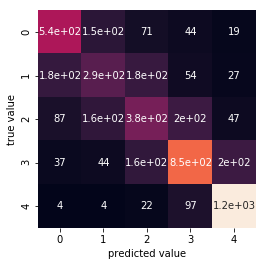

In [255]:
# Display results using KNN with the optimal number of neighbors
knn = KNeighborsClassifier(n_neighbors=4, weights='distance')
df_db_test = cv_blink(df_db_offset, X, y, knn, num_cv=5, random_state=0, use_prob=False)
df_db_blink_res = eval_blinks(df_db_test)

y_test = np.array([int(l*(levels-1)) for l in df_db_test['label']])
y_pred = np.array([int(l*(levels-1)) for l in df_db_test['prediction']])

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value')

print('Accuracy score using K-Nearest Neighbors: ',accuracy_score(y_test, y_pred))

Accuracy score per blink using K-Nearest Neighbors:  0.6818181818181818


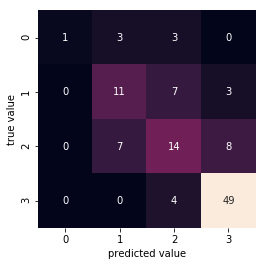

In [256]:
y_blink_test = np.array([int(l*(levels-1)) for l in df_db_blink_res['min_label']])
y_blink_pred = np.array([int(l*(levels-1)) for l in df_db_blink_res['min_pred']])

mat = confusion_matrix(y_blink_test, y_blink_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value')

print('Accuracy score per blink using K-Nearest Neighbors: ',accuracy_score(y_blink_test, y_blink_pred))

## Try Random Forest

In [269]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

parameters = {'max_features':['sqrt', 'log2', 10],
              'max_depth':[5, 7, 9]}

rf = RandomForestClassifier(n_estimators=500, random_state=0)

df_db_test = cv_blink(df_db_offset, X, y, rf, num_cv=5, random_state=0, use_prob=False)

Accuracy score using Random Forest:  0.6892555490080534


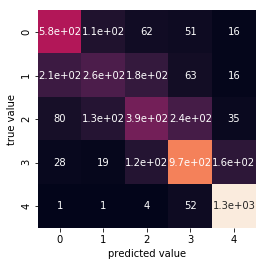

In [270]:
# Evaluate score per frame
y_test = np.array([int(l*(levels-1)) for l in df_db_test['label']])
y_pred = np.array([int(l*(levels-1)) for l in df_db_test['prediction']])

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value')

print('Accuracy score using Random Forest: ',accuracy_score(y_test, y_pred))

Accuracy score per blink using Random Forest:  0.7363636363636363


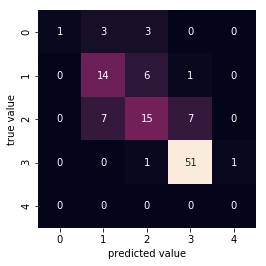

In [277]:
# Evaluate score per blink
df_db_blink_res = eval_blinks(df_db_test)

y_blink_test = np.array([int(l*(levels-1)) for l in df_db_blink_res['min_label']])
y_blink_pred = np.array([int(l*(levels-1)) for l in df_db_blink_res['min_pred']])

mat = confusion_matrix(y_blink_test, y_blink_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value')

print('Accuracy score per blink using Random Forest: ',accuracy_score(y_blink_test, y_blink_pred))

# Choose the optimal number of neighboring frames to take into account

## Show historgam of blink durations

Text(0.5, 1.0, 'Histogram of blink duration')

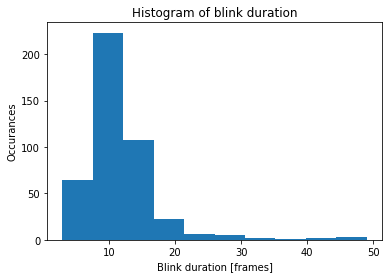

In [299]:
dur_list = []

for blink in df_db['blink_number'].unique():
    dur_list.append(len(df_db.loc[df_db['blink_number'] == blink].index))

plt.hist(dur_list)
plt.ylabel('Occurances')
plt.xlabel('Blink duration [frames]')
plt.title('Histogram of blink duration')

In [300]:
max_frames = 10

df_db_ext = df_db.copy()

for offset in range(max_frames*(-1), max_frames+1):
    # Do something only if the offset isn't zero
    if(offset == 0):
        continue
    
    # Run for each blink
    for blink_number in range(num_blinks):
        
        blink_idx = df_db.loc[df_db['blink_number'] == blink_number].index

        for i in range(len(blink_idx)):
            # Add a column for each selected feature
            for feature in features:
                new_column = feature + '_' + str(offset)
                if (i + offset < 0) or (i + offset > len(blink_idx) - 1):
                    df_db_ext.loc[blink_idx[i], new_column] = 1
                else:
                    df_db_ext.loc[blink_idx[i], new_column]  = df_db_ext.loc[blink_idx[i + offset], feature]

In [306]:
# Run for each offset, starting from zero
df_db_ext = df_db_ext.reset_index(drop=True)
offset_scores = []

for n in range(max_frames+1):
    
    # Construct a list of features to consider
    new_features = features
    for feature in features:
        add_cols = []
        for m in range(1,n+1):
            add_cols   = add_cols + [col for col in df_db_ext.columns if (col.startswith(feature) and col.endswith(str(m)))]
        new_features = new_features + add_cols
    new_features.append('palsy_eye')
    print(len(new_features))
    
    # Construct X and y vectors
    X = df_db_ext[new_features]
    y = np.array([int(l*4) for l in df_db_ext['label']])
    
    # Classify using RBF SVM
    rbfsvm = SVC(kernel='rbf', C=1000, gamma='scale', probability=False, random_state=0)
    df_db_test = cv_blink(df_db_ext, X, y, rbfsvm, num_cv=5, random_state=0, use_prob=False)
    
    # Evaluate score per blink
    df_db_blink_res = eval_blinks(df_db_test)

    y_blink_test = np.array([int(l*(levels-1)) for l in df_db_blink_res['min_label']])
    y_blink_pred = np.array([int(l*(levels-1)) for l in df_db_blink_res['min_pred']])
    
    # Append the accuracy score to the scores list
    offset_scores.append(accuracy_score(y_blink_test, y_blink_pred))

3
7
11
15
19
23
27
31
35
39
43


Text(0.5, 1.0, 'Model performance vs. number of neighboring frames')

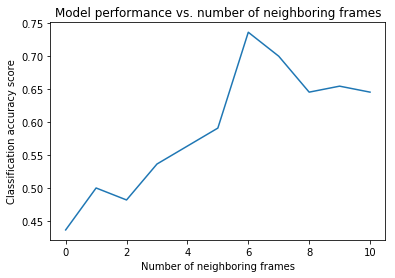

In [307]:
# Show graphs
plt.plot(range(max_frames+1),offset_scores)
plt.xlabel('Number of neighboring frames')
plt.ylabel('Classification accuracy score')
plt.title('Model performance vs. number of neighboring frames')

In [6]:
# Try assymetrical offset 
max_frames = 15

df_db_ext = df_db.copy()

for offset in range(max_frames*(-1), 0):
    # Do something only if the offset isn't zero
    if(offset == 0):
        continue
    
    # Run for each blink
    for blink_number in range(num_blinks):
        
        blink_idx = df_db.loc[df_db['blink_number'] == blink_number].index

        for i in range(len(blink_idx)):
            # Add a column for each selected feature
            for feature in features:
                new_column = feature + '_' + str(offset)
                if (i + offset < 0) or (i + offset > len(blink_idx) - 1):
                    df_db_ext.loc[blink_idx[i], new_column] = 1
                else:
                    df_db_ext.loc[blink_idx[i], new_column]  = df_db_ext.loc[blink_idx[i + offset], feature]

In [10]:
# Run for each offset, starting from zero
df_db_ext = df_db_ext.reset_index(drop=True)
offset_scores = []

for n in range(max_frames+1):
    
    # Construct a list of features to consider
    new_features = features
    for feature in features:
        add_cols = []
        for m in range(1,n+1):
            add_cols   = add_cols + [col for col in df_db_ext.columns if (col.startswith(feature) and col.endswith('-'+str(m)))]
        new_features = new_features + add_cols
    new_features.append('palsy_eye')
    print((new_features))
    
    # Construct X and y vectors
    X = df_db_ext[new_features]
    y = np.array([int(l*4) for l in df_db_ext['label']])
    
    # Classify using RBF SVM
    rbfsvm = SVC(kernel='rbf', C=1000, gamma='scale', probability=False, random_state=0)
    df_db_test = cv_blink(df_db_ext, X, y, rbfsvm, num_cv=5, random_state=0, use_prob=False)
    
    # Evaluate score per blink
    df_db_blink_res = eval_blinks(df_db_test)

    y_blink_test = np.array([int(l*(levels-1)) for l in df_db_blink_res['min_label']])
    y_blink_pred = np.array([int(l*(levels-1)) for l in df_db_blink_res['min_pred']])
    
    # Append the accuracy score to the scores list
    offset_scores.append(accuracy_score(y_blink_test, y_blink_pred))

['ear', 'poly', 'palsy_eye']
['ear', 'poly', 'ear_-1', 'poly_-1', 'palsy_eye']
['ear', 'poly', 'ear_-1', 'ear_-2', 'poly_-1', 'poly_-2', 'palsy_eye']
['ear', 'poly', 'ear_-1', 'ear_-2', 'ear_-3', 'poly_-1', 'poly_-2', 'poly_-3', 'palsy_eye']
['ear', 'poly', 'ear_-1', 'ear_-2', 'ear_-3', 'ear_-4', 'poly_-1', 'poly_-2', 'poly_-3', 'poly_-4', 'palsy_eye']
['ear', 'poly', 'ear_-1', 'ear_-2', 'ear_-3', 'ear_-4', 'ear_-5', 'poly_-1', 'poly_-2', 'poly_-3', 'poly_-4', 'poly_-5', 'palsy_eye']
['ear', 'poly', 'ear_-1', 'ear_-2', 'ear_-3', 'ear_-4', 'ear_-5', 'ear_-6', 'poly_-1', 'poly_-2', 'poly_-3', 'poly_-4', 'poly_-5', 'poly_-6', 'palsy_eye']
['ear', 'poly', 'ear_-1', 'ear_-2', 'ear_-3', 'ear_-4', 'ear_-5', 'ear_-6', 'ear_-7', 'poly_-1', 'poly_-2', 'poly_-3', 'poly_-4', 'poly_-5', 'poly_-6', 'poly_-7', 'palsy_eye']
['ear', 'poly', 'ear_-1', 'ear_-2', 'ear_-3', 'ear_-4', 'ear_-5', 'ear_-6', 'ear_-7', 'ear_-8', 'poly_-1', 'poly_-2', 'poly_-3', 'poly_-4', 'poly_-5', 'poly_-6', 'poly_-7', 'poly_-

Text(0.5, 1.0, 'Model performance vs. number of neighboring frames')

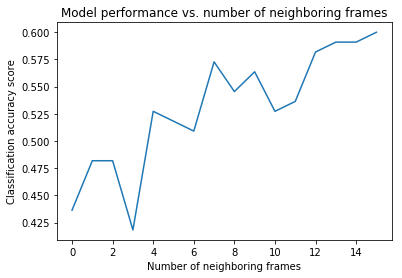

In [11]:
# Show graphs
plt.plot(range(max_frames+1),offset_scores)
plt.xlabel('Number of neighboring frames')
plt.ylabel('Classification accuracy score')
plt.title('Model performance vs. number of neighboring frames')

# Different approach: using textual features

## Extract HOG features

In [283]:
# define HOG descriptor
IMG_WIDTH = 34
IMG_HEIGHT = 26
BLOCK_SIZE = 3

# change window size so that it will be divisable by the block size
if IMG_WIDTH % BLOCK_SIZE == 0:
    win_width = IMG_WIDTH
else:
    win_width = (IMG_WIDTH // BLOCK_SIZE) * BLOCK_SIZE
    
if IMG_HEIGHT % BLOCK_SIZE == 0:
    win_height = IMG_HEIGHT
else:
    win_height = (IMG_HEIGHT // BLOCK_SIZE) * BLOCK_SIZE

# Define HOG parameters
winSize = (win_width, win_height)
blockSize = (2*BLOCK_SIZE, 2*BLOCK_SIZE)
blockStride = (BLOCK_SIZE, BLOCK_SIZE)
cellSize = (BLOCK_SIZE, BLOCK_SIZE)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)

In [285]:
# Extract features for each frame in the database
df_db_hog = df_db.copy().reset_index(drop=True)

for i in range(len(df_db.index)):
    # extract file name
    file_name  = df_db_hog.loc[i,'video_name']
    # extract eye location
    eye_loc    = df_db_hog.loc[i,'eye_location']
    # extract frame number
    frame_num  = df_db_hog.loc[i,'frame_number']
    # extract image directory
    img_dir = '../2_features_extraction/files/' + file_name + '/eye_pics/' + eye_loc + '/' + str(frame_num).zfill(3) + '.jpg'
    # read the appropriate image
    image = cv2.imread(img_dir)
    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # calculate HOG descriptor
    hist = hog.compute(gray)
    
    if i == 0:
        feature_matrix = np.transpose(hist)
    else:
        feature_matrix = np.vstack([feature_matrix, np.transpose(hist)])

## Define X and y vectors

In [292]:
feature_matrix.shape[1]

2520

In [294]:
#X = feature_matrix
X = pd.DataFrame(data=feature_matrix,                  
                 index=range(feature_matrix.shape[0]), 
                 columns=range(feature_matrix.shape[1]))     
y = np.array([int(l*4) for l in df_db_hog['label']])

## Examine the use of PCA

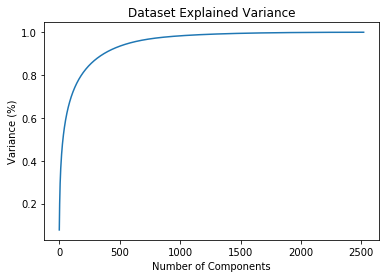

In [287]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(X)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance')
plt.show()

In [288]:
# Pefrorm PCA using a lower number support vectors
model = PCA(n_components=1700)            
model.fit(X)                      
X_PCA = model.transform(X)         

## Try SVM

### RBF SVM

In [295]:
rbfsvm = SVC(kernel='rbf', C=1000, gamma='scale', probability=False, random_state=0)
df_db_test = cv_blink(df_db_hog, X, y, rbfsvm, num_cv=5, random_state=0, use_prob=False)

Accuracy score using HOG & RBF SVM:  0.5262227460223925


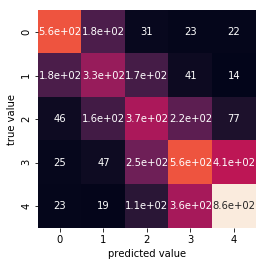

In [297]:
# Evaluate score per frame
y_test = np.array([int(l*(levels-1)) for l in df_db_test['label']])
y_pred = np.array([int(l*(levels-1)) for l in df_db_test['prediction']])

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value')

print('Accuracy score using HOG & RBF SVM: ',accuracy_score(y_test, y_pred))

Accuracy score per blink using HOG & RBF SVM:  0.5818181818181818


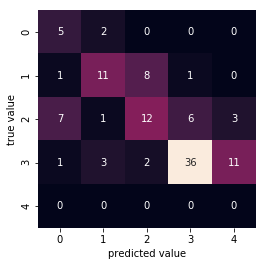

In [298]:
# Evaluate score per blink
df_db_blink_res = eval_blinks(df_db_test)

y_blink_test = np.array([int(l*(levels-1)) for l in df_db_blink_res['min_label']])
y_blink_pred = np.array([int(l*(levels-1)) for l in df_db_blink_res['min_pred']])

mat = confusion_matrix(y_blink_test, y_blink_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value')

print('Accuracy score per blink using HOG & RBF SVM: ',accuracy_score(y_blink_test, y_blink_pred))

In [191]:
min_pred  = min(df_db_test.loc[df_db_test['blink_number'] == 272].iloc[1:-1,:]['prediction'])
min_pred_idx = df_db_test.loc[(df_db_test['blink_number'] == 272) & (df_db_test['prediction'] == min_pred)].index
min_pred_mid = min_pred_idx[round(len(min_pred_idx)/2)]
min_locs = df_db_test.loc[df_db_test['blink_number'] == 272].loc[min_pred_mid-1:min_pred_mid+1,:]['prediction'].reset_index(drop=True)
print(min_pred_idx)

Int64Index([3192, 3193, 3195], dtype='int64')


In [174]:
# Train & Test using SVM
num_blinks_normal = 214
num_blinks_palsy = num_blinks - num_blinks_normal

random_state = 0
num_cv = 5

normal_choice = range(num_blinks_normal)
palsy_choice  = range(num_blinks_normal, num_blinks)

for i in range(num_cv):
    test_mask = np.zeros(len(X), dtype=bool)
    np.random.seed(random_state); rnd_idx_normal = sorted(np.random.choice(normal_choice, min(len(normal_choice),int(np.round(num_blinks_normal/num_cv))), replace=False))
    np.random.seed(random_state); rnd_idx_palsy = sorted(np.random.choice(palsy_choice, min(len(palsy_choice),int(np.round(num_blinks_palsy/num_cv))), replace=False))
    test_mask = np.zeros(len(X), dtype=bool)
    test_mask[df_db_offset.loc[df_db_offset['blink_number'].isin(rnd_idx_normal)].index] = True
    test_mask[df_db_offset.loc[df_db_offset['blink_number'].isin(rnd_idx_palsy)].index] = True
    Xtest, ytest = X[test_mask], y[test_mask]
    Xtrain, ytrain = X[~test_mask], y[~test_mask]
    
    print('shapes: \n Xtrain : {}\n Xtest: {}\n ytrain: {}\n ytest: {}'.\
      format(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape))

    model = SVC(kernel='rbf', C=1000, gamma='scale', probability=True, random_state=0)                       # 2. instantiate model
    model.fit(Xtrain, ytrain)                  # 3. fit model to data
    y_model = model.predict(Xtest)             # 4. predict on new data
    
    df_db_test_cv = df_db.iloc[Xtest.index,:]
    df_db_test_cv.loc[:,'prediction'] = y_model / (levels - 1)
    
    pred_pro = model.predict_proba(Xtest)
    
    for j in range(levels):
        col_name = 'prob_' + str(j)
        df_db_test_cv.loc[:,col_name] = pred_pro[:,j] 
    
    if i==0:
        df_db_test = df_db_test_cv.copy()
    else:
        df_db_test = pd.concat([df_db_test, df_db_test_cv])
        
    normal_choice = [num for num in normal_choice if not (num in rnd_idx_normal)]
    palsy_choice = [num for num in palsy_choice if not (num in rnd_idx_palsy)]
    
    print(len(normal_choice))

shapes: 
 Xtrain : (4097, 27)
 Xtest: (1018, 27)
 ytrain: (4097,)
 ytest: (1018,)


C:\Users\user\AppData\Local\conda\conda\envs\opencv-env\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\user\AppData\Local\conda\conda\envs\opencv-env\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\user\AppData\Local\conda\conda\envs\opencv-env\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

171
shapes: 
 Xtrain : (4122, 27)
 Xtest: (993, 27)
 ytrain: (4122,)
 ytest: (993,)


C:\Users\user\AppData\Local\conda\conda\envs\opencv-env\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\user\AppData\Local\conda\conda\envs\opencv-env\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\user\AppData\Local\conda\conda\envs\opencv-env\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

128
shapes: 
 Xtrain : (4146, 27)
 Xtest: (969, 27)
 ytrain: (4146,)
 ytest: (969,)


C:\Users\user\AppData\Local\conda\conda\envs\opencv-env\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\user\AppData\Local\conda\conda\envs\opencv-env\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\user\AppData\Local\conda\conda\envs\opencv-env\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

85
shapes: 
 Xtrain : (4075, 27)
 Xtest: (1040, 27)
 ytrain: (4075,)
 ytest: (1040,)


C:\Users\user\AppData\Local\conda\conda\envs\opencv-env\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\user\AppData\Local\conda\conda\envs\opencv-env\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\user\AppData\Local\conda\conda\envs\opencv-env\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

42
shapes: 
 Xtrain : (4044, 27)
 Xtest: (1071, 27)
 ytrain: (4044,)
 ytest: (1071,)


C:\Users\user\AppData\Local\conda\conda\envs\opencv-env\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\user\AppData\Local\conda\conda\envs\opencv-env\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\user\AppData\Local\conda\conda\envs\opencv-env\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

0


Accuracy score using RBF SVM:  0.6668630917305048


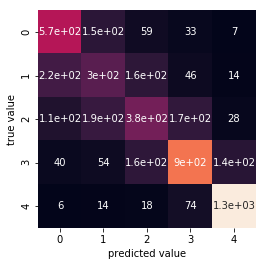

In [176]:
y_test = np.array([int(l*(levels-1)) for l in df_db_test['label']])
y_pred = np.array([int(l*(levels-1)) for l in df_db_test['prediction']])

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value')

print('Accuracy score using RBF SVM: ',accuracy_score(y_test, y_pred))

=== BLINK NUMBER 219 ===
Minimum label:  0.75
Minimum prediction:  0.75
Palsy eye:  1
Max prob:  0.4868106692019133
=== BLINK NUMBER 232 ===
Minimum label:  0.0
Minimum prediction:  0.0
Palsy eye:  1
Max prob:  0.4868106692019133
=== BLINK NUMBER 251 ===
Minimum label:  0.75
Minimum prediction:  0.75
Palsy eye:  1
Max prob:  0.4868106692019133
=== BLINK NUMBER 258 ===
Minimum label:  0.5
Minimum prediction:  0.25
Palsy eye:  1
Max prob:  0.4868106692019133
=== BLINK NUMBER 269 ===
Minimum label:  0.75
Minimum prediction:  0.75
Palsy eye:  1
Max prob:  0.4868106692019133
=== BLINK NUMBER 323 ===
Minimum label:  0.5
Minimum prediction:  0.5
Palsy eye:  1
Max prob:  0.4868106692019133
=== BLINK NUMBER 358 ===
Minimum label:  0.75
Minimum prediction:  0.75
Palsy eye:  1
Max prob:  0.4868106692019133
=== BLINK NUMBER 363 ===
Minimum label:  0.75
Minimum prediction:  0.75
Palsy eye:  1
Max prob:  0.4868106692019133
=== BLINK NUMBER 380 ===
Minimum label:  0.25
Minimum prediction:  0.5
Palsy 

Minimum label:  0.5
Minimum prediction:  0.5
Palsy eye:  1
Max prob:  0.4868106692019133
=== BLINK NUMBER 333 ===
Minimum label:  0.5
Minimum prediction:  0.5
Palsy eye:  1
Max prob:  0.4868106692019133
=== BLINK NUMBER 334 ===
Minimum label:  0.75
Minimum prediction:  0.75
Palsy eye:  1
Max prob:  0.4868106692019133
=== BLINK NUMBER 347 ===
Minimum label:  0.75
Minimum prediction:  0.75
Palsy eye:  1
Max prob:  0.4868106692019133
=== BLINK NUMBER 350 ===
Minimum label:  0.75
Minimum prediction:  0.75
Palsy eye:  1
Max prob:  0.4868106692019133
=== BLINK NUMBER 351 ===
Minimum label:  0.5
Minimum prediction:  0.5
Palsy eye:  1
Max prob:  0.4868106692019133
=== BLINK NUMBER 360 ===
Minimum label:  0.5
Minimum prediction:  0.5
Palsy eye:  1
Max prob:  0.4868106692019133
=== BLINK NUMBER 362 ===
Minimum label:  0.5
Minimum prediction:  0.5
Palsy eye:  1
Max prob:  0.4868106692019133
=== BLINK NUMBER 378 ===
Minimum label:  0.25
Minimum prediction:  0.5
Palsy eye:  1
Max prob:  0.486810669

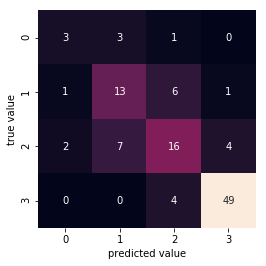

In [177]:
df_db_test = df_db_test.reset_index(drop=True)
df_db_test['max_prob'] = df_db_test[['prob_0','prob_1','prob_2','prob_3','prob_4']].max(axis=1)

y_blink_test = []
y_blink_pred = []

for blink in df_db_test['blink_number'].unique():
    palsy_eye = min(df_db_test.loc[df_db_test['blink_number'] == blink]['palsy_eye'])
    if palsy_eye == 1:
        print("=== BLINK NUMBER " + str(blink) + " ===")
        min_label = min(df_db_test.loc[df_db_test['blink_number'] == blink].iloc[1:-1,:]['label'])
        y_blink_test.append(int(min_label * (levels - 1)))
        min_pred  = min(df_db_test.loc[df_db_test['blink_number'] == blink].iloc[1:-1,:]['prediction'])
        min_pred_idx = df_db_test.loc[(df_db_test['blink_number'] == blink) & (df_db_test['prediction'] == min_pred)].index
        min_pred_mid = min_pred_idx[round(len(min_pred_idx)/2)]
        min_locs = df_db_test.loc[df_db_test['blink_number'] == blink].loc[min_pred_mid-1:min_pred_mid+1,:]['prediction'].reset_index(drop=True)
        if (min_pred == 0.5 and min_locs[0] == 0.75 and min_locs[2] == 0.75):
            min_pred_final = min_pred
        elif (min_pred == 0 and min_locs[0] == 0.75 and min_locs[2] == 1):
            min_pred_final = min_pred
        elif (min_pred == 0 and min_locs[0] == 0.25 and min_locs[2] == 0.5):
            min_pred_final = min_pred
        elif (min_pred == 0.25 and min_locs[0] == 1 and min_locs[2] == 0.75):
            min_pred_final = min_pred
        else:
            min_pred_final = np.median(min_locs)
        
        y_blink_pred.append(int(min_pred_final * (levels - 1)))
        print("Minimum label: ", min_label)
        print("Minimum prediction: ", min_pred_final)
        print("Palsy eye: ", palsy_eye)
        print("Max prob: ", probs['max_prob'])

mat = confusion_matrix(y_blink_test, y_blink_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value')

print('Accuracy score: ',accuracy_score(y_blink_test, y_blink_pred))

In [119]:
min_locs

755    0.50
756    0.50
757    0.75
Name: prediction, dtype: float64

In [157]:
df_test_prob = df_db_test[['blink_number','video_name','frame_number','eye_location','label','prob_0','prob_1','prob_2','prob_3','prob_4','prediction']]
df_test_prob['max_prob'] = df_test_prob[['prob_0','prob_1','prob_2','prob_3','prob_4']].max(axis=1)
#df_test_conf = df_test_prob.loc[df_test_prob['max_prob'] < 0.5, :]
df_test_prob.loc[df_test_prob['blink_number'] == 382]

C:\Users\user\AppData\Local\conda\conda\envs\opencv-env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,blink_number,video_name,frame_number,eye_location,label,prob_0,prob_1,prob_2,prob_3,prob_4,prediction,max_prob
2811,382,palsy_17_r_30fps,206,right,1.00,0.031241,0.013162,0.013378,0.116311,0.825909,1.00,0.825909
2812,382,palsy_17_r_30fps,207,right,0.75,0.032419,0.014802,0.071255,0.094989,0.786535,1.00,0.786535
2813,382,palsy_17_r_30fps,208,right,0.50,0.056362,0.054715,0.184680,0.525341,0.178902,0.75,0.525341
2814,382,palsy_17_r_30fps,209,right,0.25,0.037199,0.193679,0.263610,0.502595,0.002916,0.75,0.502595
2815,382,palsy_17_r_30fps,210,right,0.50,0.010536,0.070181,0.252668,0.665342,0.001273,0.75,0.665342
2816,382,palsy_17_r_30fps,211,right,0.75,0.000603,0.002310,0.088505,0.897612,0.010970,0.75,0.897612
2817,382,palsy_17_r_30fps,212,right,1.00,0.000958,0.004379,0.009735,0.194274,0.790655,1.00,0.790655
2818,382,palsy_17_r_30fps,241,right,0.75,0.001571,0.000436,0.008255,0.142716,0.847022,1.00,0.847022
